<a href="https://colab.research.google.com/github/rajeev2712/repo1_gen/blob/master/Time_Series_Session_01_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DART

**Time Series Made Easy in Python**


darts is a Python library for easy manipulation and forecasting of time series. It contains a variety of models, from classics such as ARIMA to deep neural networks. The models can all be used in the same way, using fit() and predict() functions, similar to scikit-learn. The library also makes it easy to backtest models, combine the predictions of several models, and take external data into account. Darts supports both univariate and multivariate time series and models. The ML-based models can be trained on potentially large datasets containing multiple time series, and some of the models offer a rich support for probabilistic forecasting.

## Motivation

If you are a data scientist working with time series you already know this: time series are special beasts. With regular tabular data, you can often just use scikit-learn for doing most ML things — from preprocessing to prediction and model selection. But with time series, the story is different. You can easily end up in situations where you need one library for pre-processing (e.g. Pandas to interpolate missing values and re-sample), another to detect seasonality (e.g. statsmodels), a third one to fit a forecasting model (e.g. Facebook Prophet), and finally more often than not you’ll have to implement your own backtesting and model selection routines. This can be quite tedious, as most libraries use different APIs and data types.


![link text](https://miro.medium.com/max/1400/1*yaHh5V0AgxEYxJYrv9VQmA.png)





- A very easy time series analysis library
- Allows  univariate and multivariate time series fore-casting.
- Has models like `arima`, `auto-arima`, `deep neural networks`
- Similar to sklearn
- Uses fit and predict method


Darts already contains working implementations of the following forecasting models:


*   Exponential smoothing
*   (V)ARIMA & auto-ARIMA (including seasonal)
*   Facebook Prophet
*   Theta method
*   FFT (Fast Fourier Transform)
*   Recurrent neural networks (vanilla RNNs, GRU, and LSTM variants)
*   Temporal Convolutional Networks (TCN)
*   N-BEATS
*   Transformer
*   DeepAR
*   DeepTCN
*   Regression forecasting models: these models allow to predict future values based on certain lagged values of the target and covariate series, using an other regression model (e.g. a scikit-learn regression model)
*   and several naive baselines


Let's start.

In [ ]:
!pip install darts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pyyaml==5.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.datasets import AirPassengersDataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


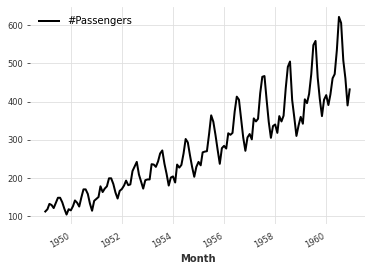

In [ ]:
series = AirPassengersDataset().load()
series.plot()

Adding some binary holidays component:

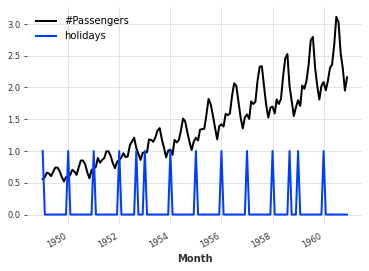

In [ ]:
(series / 200).add_holidays("US").plot()

Creating a training and validation series
For what follows, we will split our TimeSeries into a training and a validation series. Note: in general, it is also a good practice to keep a test series aside and never touch it until the end of the process. Here, we just build a training and a validation series for simplicity.

The training series will be a TimeSeries containing values until January 1958 (excluded), and the validation series a TimeSeries containing the rest:

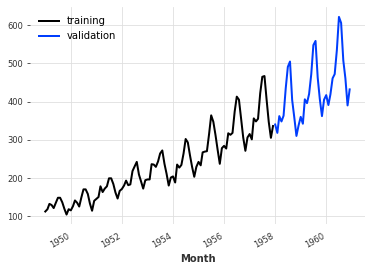

In [ ]:
train, val = series.split_before(pd.Timestamp("19580101"))
train.plot(label="training")
val.plot(label="validation")

## Training forecasting models and making predictions



There is a collection of "naive" baseline models in Darts, which can be very useful to get an idea of the bare minimum accuracy that one could expect. For example, the NaiveSeasonal(K) model always "repeats" the value that occured K time steps ago.

In its most naive form, when K=1, this model simply always repeats the last value of the training series:

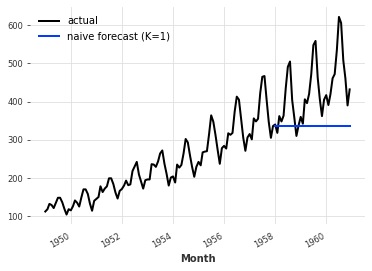

In [ ]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(36)

series.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)")

It's very easy to fit models and produce predictions on TimeSeries. All the models have a fit() and a predict() function. This is similar to Scikit-learn, except that it is specific to time series. The fit() function takes in argument the training time series on which to fit the model, and the predict() function takes in argument the number of time steps (after the end of the training series) over which to forecast.


## Inspect Seasonality

Our model above is perhaps a bit too naive. We can already improve by exploiting the seasonality in the data. It seems quite obvious that the data has a yearly seasonality, which we can confirm by looking at the auto-correlation function (ACF), and highlighting the lag m=12:

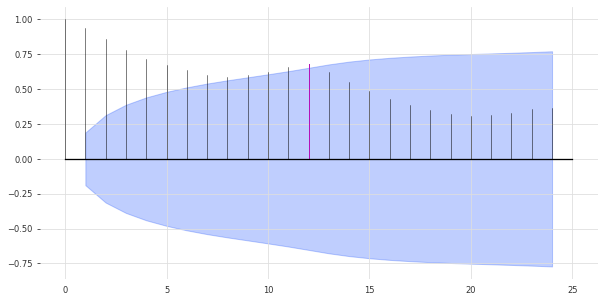

In [ ]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, m=12, alpha=0.05)

The ACF presents a spike at x = 12, which suggests a yearly seasonality trend (highlighted in red). The blue zone determines the significance of the statistics for a confidence level of . We can also run a statistical check of seasonality for each candidate period m:

In [ ]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 12.


## A less naive model

Let's try the NaiveSeasonal model again with a seasonality of 12:

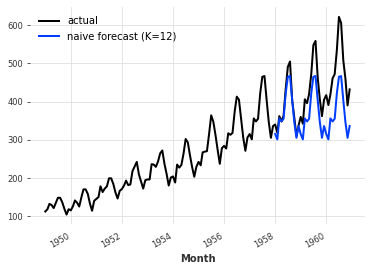

In [ ]:
seasonal_model = NaiveSeasonal(K=12)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(36)

series.plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=12)")

This is better, but we are still missing the trend. Fortunately, there is also another naive baseline model capturing the trend, which is called NaiveDrift. This model simply produces linear predictions, with a slope that is determined by the first and last values of the training set:

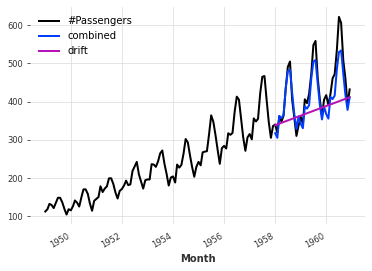

In [ ]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(36)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

What happened there? We simply fit a naive drift model, and add its forecast to the seasonal forecast we had previously. We also subtract the last value of the training set from the result, so that the resulting combined forecast starts off with the right offset.

## Computing error metrics

This looks already like a fairly decent forecast, and we did not use any non-naive model yet. In fact - any model should be able to beat this.

So what's the error we will have to beat? We will use the Mean Absolute Percentage Error (MAPE) (note that in practice there are often good reasons not to use the MAPE - we use it here as it is quite convenient and scale independent). In Darts it is a simple function call:

In [ ]:
from darts.metrics import mape

print(
    "Mean absolute percentage error for the combined naive drift + seasonal: {:.2f}%.".format(
        mape(series, combined_forecast)
    )
)

Mean absolute percentage error for the combined naive drift + seasonal: 5.66%.


**darts.metrics** contains many more metrics to compare time series. The metrics will compare only common slices of series when the two series are not aligned, and parallelize computation over a large number of pairs of series - but let's not get ahead of ourselves.

In [ ]:
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta


def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(val, forecast)))


eval_model(ExponentialSmoothing())
eval_model(TBATS())
eval_model(AutoARIMA())
eval_model(Theta())

model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=12 obtains MAPE: 5.11%
model (T)BATS obtains MAPE: 5.87%
model Auto-ARIMA obtains MAPE: 11.65%
model Theta(2) obtains MAPE: 8.15%


## Searching for hyper-parameters with the Theta method

The model Theta contains an implementation of Assimakopoulos and Nikolopoulos' Theta method. This method has had some success, particularly in the M3-competition.

Though the value of the Theta parameter is often set to 0 in applications, our implementation supports a variable value for parameter tuning purposes. Let's try to find a good value for Theta:

In [ ]:
# Search for the best theta parameter, by trying 50 different values
thetas = 2 - np.linspace(-10, 10, 50)

best_mape = float("inf")
best_theta = 0

for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(val))
    res = mape(val, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta

In [ ]:
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(val))

print(
    "The MAPE is: {:.2f}, with theta = {}.".format(
        mape(val, pred_best_theta), best_theta
    )
)

The MAPE is: 4.40, with theta = -3.5102040816326543.


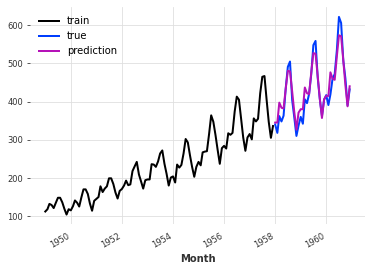

In [ ]:
train.plot(label="train")
val.plot(label="true")
pred_best_theta.plot(label="prediction")

We can observe that the model with best_theta is so far the best we have, in terms of MAPE.

## Backtesting: simulate historical forecasting


So at this point we have a model that performs well on our validation set, and that's good. But, how can we know the performance we would have obtained if we had been using this model historically?

Backtesting simulates predictions that would have been obtained historically with a given model. It can take a while to produce, since the model is (by default) re-trained every time the simulated prediction time advances.

Such simulated forecasts are always defined with respect to a forecast horizon, which is the number of time steps that separate the prediction time from the forecast time. In the example below, we simulate forecasts done for 3 months in the future (compared to prediction time). The result of calling historical_forecasts() is (by default) a TimeSeries that contains those 3-months ahead forecasts:

100%|██████████| 57/57 [00:01<00:00, 38.87it/s]


MAPE = 7.70%


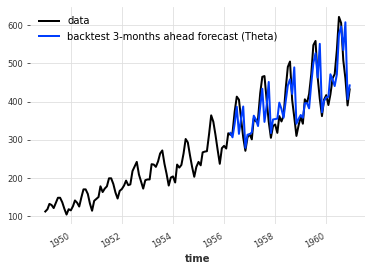

In [ ]:
historical_fcast_theta = best_theta_model.historical_forecasts(
    series, start=0.6, forecast_horizon=3, verbose=True
)

series.plot(label="data")
historical_fcast_theta.plot(label="backtest 3-months ahead forecast (Theta)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_theta, series)))

So it seems that our best model on validation set is not doing so great anymore when we backtest it (did I hear overfitting :D)

To have a closer look at the errors, we can also use the backtest() method to obtain all the raw errors (say, MAPE errors) that would have been obtained by our model:

100%|██████████| 57/57 [00:01<00:00, 37.86it/s]


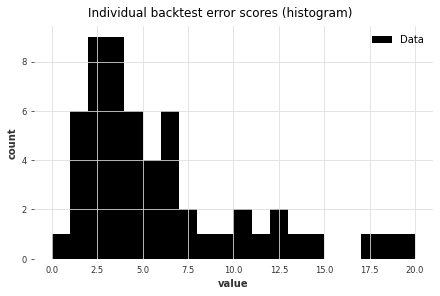

In [ ]:
best_theta_model = Theta(best_theta)

raw_errors = best_theta_model.backtest(
    series, start=0.6, forecast_horizon=3, metric=mape, reduction=None, verbose=True
)

from darts.utils.statistics import plot_hist

plot_hist(
    raw_errors,
    bins=np.arange(0, max(raw_errors), 1),
    title="Individual backtest error scores (histogram)",
)

Finally, using backtest() we can also get a simpler view of the average error over the historical forecasts:

In [ ]:
average_error = best_theta_model.backtest(
    series,
    start=0.6,
    forecast_horizon=3,
    metric=mape,
    reduction=np.mean,  # this is actually the default
    verbose=True,
)

print("Average error (MAPE) over all historical forecasts: %.2f" % average_error)

100%|██████████| 57/57 [00:01<00:00, 38.39it/s]


Average error (MAPE) over all historical forecasts: 6.36


We could also for instance have specified the argument reduction=np.median to get the median MAPE instead.

## Looking at residuals

Let's look at the fitted value residuals of our current Theta model, i.e. the difference between the 1-step forecasts at every point in time obtained by fitting the model on all previous points, and the actual observed values:

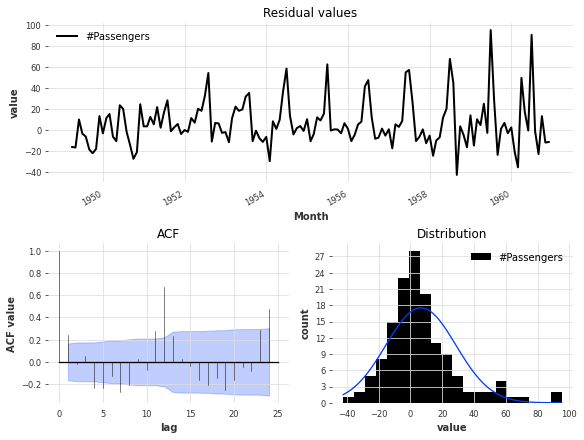

In [ ]:
from darts.utils.statistics import plot_residuals_analysis

plot_residuals_analysis(best_theta_model.residuals(series))

We can see that the distribution is not centered at 0, which means that our Theta model is biased. We can also make out a large ACF value at lag equal to 12, which indicates that the residuals contain information that was not used by the model.

## A better model

Could we maybe do better with a simple ExponentialSmoothing model?

100%|██████████| 57/57 [00:05<00:00,  9.84it/s]


MAPE = 4.45%


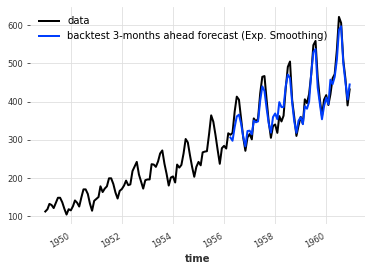

In [ ]:
model_es = ExponentialSmoothing()
historical_fcast_es = model_es.historical_forecasts(
    series, start=0.6, forecast_horizon=3, verbose=True
)

series.plot(label="data")
historical_fcast_es.plot(label="backtest 3-months ahead forecast (Exp. Smoothing)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_es, series)))

This much better! We get a mean absolute percentage error of about 4-5% when backtesting with a 3-months forecast horizon in this case.

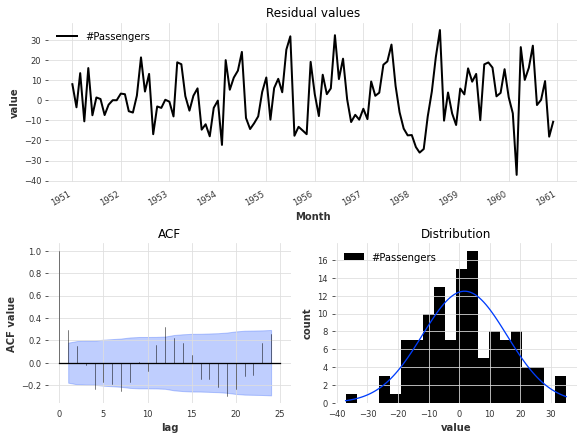

In [ ]:
plot_residuals_analysis(model_es.residuals(series))

The residual analysis also reflects an improved performance in that we now have a distribution of the residuals centred at value 0, and the ACF values, although not insignificant, have lower magnitudes.

## Machine learning and global models

Darts has a rich support for machine learning and deep learning forecasting models; for instance:


*   RegressionModel can wrap around any sklearn-compatible regression model to produce forecasts
*   RNNModel is a flexible RNN implementation, which can be used like DeepAR
*   NBEATSModel implements the N-BEATS model
*   TFTModel implements the Temporal Fusion Transformer model
*   TCNModel implements temporal convolutional networks


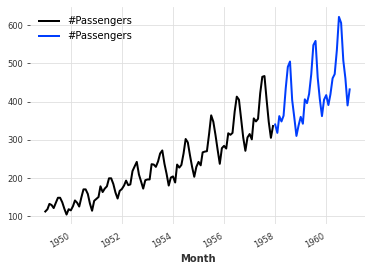

In [ ]:
from darts.datasets import AirPassengersDataset

series_air = AirPassengersDataset().load().astype(np.float32)
# set aside last 36 months of each series as validation set:
train_air, val_air = series_air[:-36], series_air[-36:]

train_air.plot()
val_air.plot()

First, let's scale these two series between 0 and 1, as that will benefit most ML models. We will use a Scaler for this:

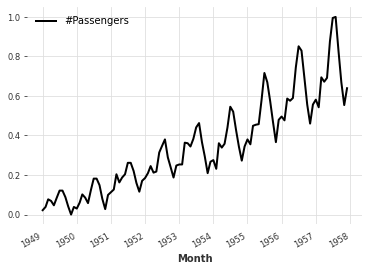

In [ ]:
from darts.dataprocessing.transformers import Scaler

scaler = Scaler()
train_air_scaled = scaler.fit_transform(train_air)

train_air_scaled.plot()

## Covariates: using external data

In addition to the target series (the series we are interested to forecast), many models in Darts also accept covariates series in input. Covariates are series that we do not want to forecast, but which can provide helpful additional information to the models. Both the targets and covariates can be multivariate or univariate.

There are two kinds of covariate time series in Darts:


*   **past_covariates** are series not necessarily known ahead of the forecast time. Those can for instance represent things that have to be measured and are not known upfront. Models do not use the future values of **past_covariates** when making forecasts.

*   **future_covariates** are series which are known in advance, up to the forecast horizon. This can represent things such as calendar information, holidays, weather forecasts, etc. Models that accept **future_covariates** will look at the future values (up to the forecast horizon) when making forecasts




![link text](https://github.com/unit8co/darts/raw/945ded5f7dd76664e5c47442f1896b4bd3230254/examples/static/images/covariates-highlevel.png)

Let's now build some external covariates containing both monthly and yearly values for our air series. In the cell below, we use the darts.utils.timeseries_generation.datetime_attribute_timeseries() function to generate series containing the month and year values, and we concatenate() these series along the "component" axis in order to obtain one covariate series with two components (month and year), per target series. For simplicity, we directly scale the month and year values to have them between (roughly) 0 and 1:

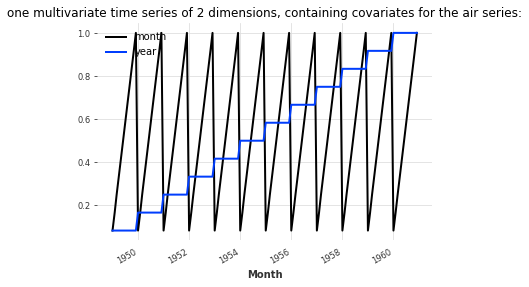

In [ ]:
from darts import concatenate
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr

air_covs = concatenate(
    [
        dt_attr(series_air.time_index, "month", dtype=np.float32) / 12,
        (dt_attr(series_air.time_index, "year", dtype=np.float32) - 1948) / 12,
    ],
    axis="component",
)
air_covs.plot()
plt.title(
    "one multivariate time series of 2 dimensions, containing covariates for the air series:"
);

## Regression forecasting models

RegressionModel's are forecasting models which wrap around sklearn-compatible regression models. The inner regression model is used to predict future values of the target series, as a function of certain lags of the target, past and future covariates. Behind the scenes, the time series are tabularized in order to build a training dataset in the right format.

By default, the RegressionModel will do a linear regression. It is very easy to use any desired sklearn-compatible regression model by specifying the model parameter, but for convenience Darts also provides a couple of ready-made models out of the box:

RandomForest wraps around sklearn.ensemble.RandomForestRegressor.
LightGBMModel wraps around lightbm.
LinearRegressionModel wraps around sklearn.linear_model.LinearRegression (accepting the same kwargs).

In [ ]:
from darts.models import RegressionModel
from sklearn.linear_model import BayesianRidge

model = RegressionModel(lags=72, lags_future_covariates=[-6, 0], model=BayesianRidge())

model.fit(train_air_scaled, future_covariates=air_covs);

**Several things happened above:**


*   lags=72 is telling the RegressionModel to look at the past 72 lags of the target.
*   In addition, lags_future_covariates=[-6, 0] means that the model will also look at lags of the future_covariates we provide. Here we enumerate the precise lags we want the models to take into account; the "-6th" and the "0th" lags. The "0th" lag means the "current" lag (i.e., at the time step being forecasted); obviously, knowning this lag requires knowing the data in advance (hence the fact we are using future_covariates). Similarly, -6 means we also look at the value of the covariates 6 months before the forecasted time step (which also requires to know the covariates in advance if we are forecasting at a horizon more than 6 steps ahead).
*   model=BayesianRidge() provides the actual inner regression model

Now let's get some forecasts:

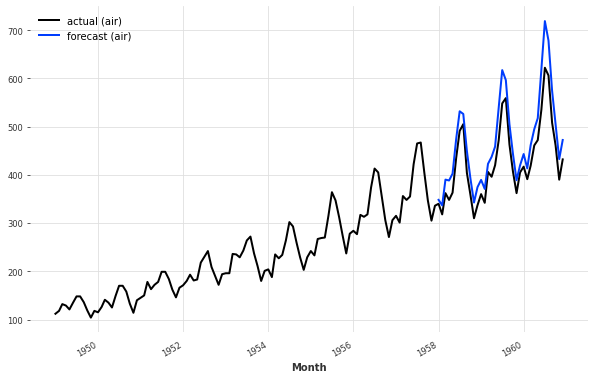

In [ ]:
pred_air = model.predict(
    series=train_air_scaled,
    future_covariates=air_covs,
    n=36,
)

# scale back:
pred_air = scaler.inverse_transform(pred_air)

plt.figure(figsize=(10, 6))
series_air.plot(label="actual (air)")
pred_air.plot(label="forecast (air)")

In [ ]:
mape(series_air, pred_air)

9.171363813865899

Check Backtesting

100%|██████████| 57/57 [00:05<00:00, 11.06it/s]


MAPE = 3.66


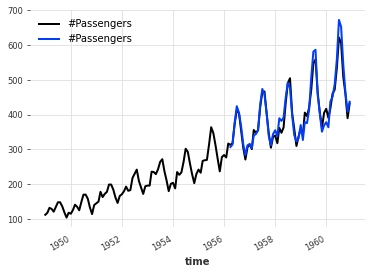

In [ ]:
bayes_ridge_model = RegressionModel(
    lags=72, lags_future_covariates=[0], model=BayesianRidge()
)

backtest = bayes_ridge_model.historical_forecasts(
    series_air, future_covariates=air_covs, start=0.6, forecast_horizon=3, verbose=True
)

print("MAPE = %.2f" % (mape(backtest, series_air)))
series_air.plot()
backtest.plot()

##Ensembling models


Ensembling is about combining the forecasts produced by several models, in order to obtain a final - and hopefully better forecast.

We can sometimes do better if we see the ensembling as a supervised regression problem: given a set of forecasts (features), find a model that combines them in order to minimise errors on the target. This is what the **RegressionEnsembleModel** does. It accepts three parameters:



*   **forecasting_models** is a list of forecasting models whose predictions we want to ensemble.
*   **regression_train_n_points** is the number of time steps to use for fitting the "ensemble regression" model (i.e., the inner model that combines the forecasts)

*   **regression_model** is, optionally, a sklearn-compatible regression model or a Darts RegressionModel to be used for the ensemble regression. If not specified, a linear regression is used. Using a sklearn model is easy out-of-the-box, but using a RegressionModel allows to potentially take arbitrary lags of the individual forecasts as inputs of the regression model.


Once these elements are in place, a RegressionEnsembleModel can be used like a regular forecasting model:

100%|██████████| 57/57 [00:02<00:00, 26.55it/s]


MAPE = 4.85


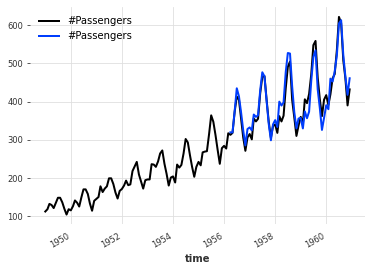

In [ ]:
from darts.models import RegressionEnsembleModel

models = [NaiveDrift(), NaiveSeasonal(12)]

ensemble_model = RegressionEnsembleModel(
    forecasting_models=models, regression_train_n_points=12
)

backtest = ensemble_model.historical_forecasts(
    series_air, start=0.6, forecast_horizon=3, verbose=True
)

print("MAPE = %.2f" % (mape(backtest, series_air)))
series_air.plot()
backtest.plot()

In [ ]:
# We can also inspect the coefficients used to weigh the two inner models in the linear combination:

ensemble_model.regression_model.model.coef_

array([0.09948264, 1.0118142 ])